In [1]:
!pip install neo4j
!pip install python-igraph
!pip install easygui
!pip install cairocffi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from neo4j import GraphDatabase
import igraph as ig
from skimage.io import imread
import glob
import seaborn as sns 
import matplotlib.pyplot as plt 
import os
import pandas as pd
import warnings
import random
import numpy as np
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [58]:
z = ig.Graph.Read_GraphML("/content/drive/My Drive/ALSSN/zurich.graphml")

In [5]:
z.edge_attributes(), z.vertex_attributes()

(['weight', 'label', 'id'], ['location', 'id', 'labels'])

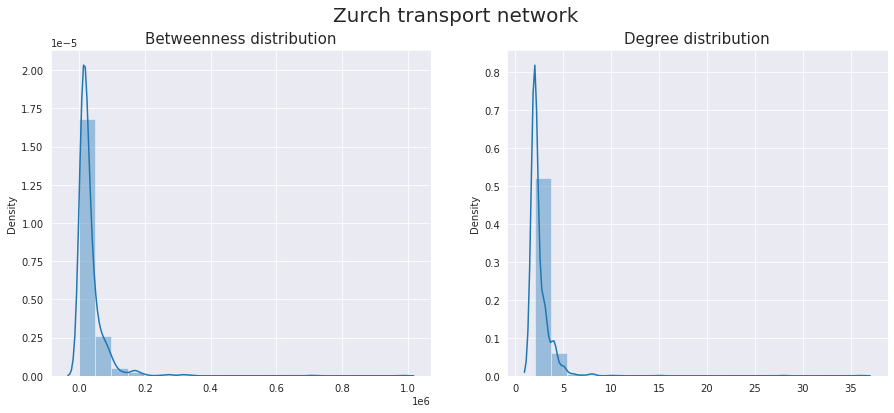

In [6]:
btw = z.betweenness()
deg = z.degree()
sns.set_style('darkgrid')
plt.figure(figsize=(15,6))
plt.suptitle('Zurch transport network', fontsize=20)
plt.subplot(121)
sns.distplot(btw, bins=20)
plt.title('Betweenness distribution', fontsize=15)
plt.subplot(122)
sns.distplot(deg, bins=20)
plt.title('Degree distribution', fontsize=15);

In [7]:
z.vcount(), z.is_directed(), z.is_weighted()

(1346, True, True)

In [68]:
# for c in glob.glob('*png'):
#   os.remove(c)

In [69]:
def generate_graph(graph, modules, iteration=None, delete_previous_plots=True, layout='auto'):
  if not os.path.exists('clusters/'):
    os.mkdir('clusters/')
    
  if delete_previous_plots and iteration==1:
    for c in glob.glob('clusters/cluster*png'):
      os.remove(c)

  layout_gr = graph.layout(layout)

  colors =np.random.permutation(sns.color_palette("hls", len(modules))).tolist()
  #colors = sns.color_palette("hls", k)
  graph.vs['color'] = [None]
  for clid, cluster in enumerate(modules):
      for member in cluster:
          graph.vs[member]['color'] = colors[clid]

  visual_style = {}
  visual_style["vertex_size"] = 5
  visual_style["vertex_label"]=None
  visual_style["vertex_color"] = graph.vs['color']
  visual_style["layout"] = layout_gr
  visual_style["edge_width"] = 1
  visual_style["bbox"] = (300, 300)
  pl = ig.plot(graph, **visual_style)
  if iteration:
    pl.save('clusters/clusters_{}_iter{}.png'.format(len(modules), iteration))
  else:
    pl.save('clusters/clusters_{}.png'.format(len(modules)))
  #return pl

def plot_graphs(img_path='clusters/', plot_limit=20, sample=False):
  i = 1
  # retrieve image fileanmes and sort them accordingly to iteration
  img_list = glob.glob(os.path.join(img_path,'cluster*.png'))

  # sample images or pick the first 0 to plot_limit ones
  if sample and len(img_list) > plot_limit:
    img_list = random.sample(img_list, plot_limit)
  else:
    img_list = img_list[:plot_limit]

  img_list.sort(key = lambda x: int(x.split('_')[-1][4:-4]))
  
  # set subplot dimensions
  if len(img_list)%2!=0:
    rows = len(img_list)//2
    cols = len(img_list)//4 + 1
  else:
    rows = len(img_list)//2
    cols = len(img_list)//4

  if rows==0 and cols==0:
    rows = 1
    cols=1
  elif rows == 0:
    rows=1

  for imf in img_list:
      im = imread(imf)
      plt.subplot(rows,cols,i)
      plt.imshow(im)
      t = 'iteration ' + imf.split('_')[-1][4:-4] + '\n' +'n_clusters: ' + imf.split('_')[1] 
      plt.title(t, fontsize=15)
      plt.xticks([])
      plt.yticks([])
      i += 1

2) Analysis carried out in a subgraph. The largest subgraph is selected and, iteratively, the node with the highest centrality is removed from the subgraph, then the communities are computed with the Louvain algorithm. (other measures such as shortest path, betweenness, modularity, have to be added and stored in a df for the following analysis)

In [70]:
def get_most_central_node(subgraph, method='eig_cent'):
  if method=='btw':
    # Approach of most central node selection taken from excercise session 3
    #wdeg = subgraph.strength()
    betw = subgraph.betweenness()
    # Select node with the highest degree and betweenness
    #vid = subgraph.vs[np.where((wdeg==np.amax(wdeg)) & (betw==np.amax(betw)))[0][0]].index
    vid = subgraph.vs[np.where(betw==np.amax(betw))[0][0]].index
  elif method=='eig_cent':
    cent = subgraph.eigenvector_centrality()
    vid = subgraph.vs[np.argmax(cent)].index
  
  return vid


In [71]:
def compute_shortest_path(graph, pairs):
  shortest_paths = {}
  for p in pairs:
    shortest_paths[str(p)] = graph.get_shortest_paths(p[0], to=p[1], weights=graph.es["weight"], output="vpath",)
  return shortest_paths

def process(graph_undirected, pairs, iterations=10, save_plots=True):
  metrics = pd.DataFrame(columns=['subgraph', 'modules', 'iteration', 'betweenness', 'shortest_path', 'modularity'])
  for i in range(iterations):
    if i==0:
      # in the first iteration we don't remove anything, we just compute the baseline measures
      subgraph = graph_undirected.clusters().giant()
      msg = 'number of nodes: {}, number of edges: {}'.format(subgraph.vcount(), subgraph.ecount())
    else:
      # get most central vertex
      v_id = get_most_central_node(subgraph, method='btw') 
      # remove from subgraph
      subgraph.delete_vertices(v_id)
      msg = 'removed node: {}, number of nodes: {}, number of edges: {}'.format(v_id, subgraph.vcount(), subgraph.ecount())
    lvn = subgraph.community_multilevel()
    row = pd.Series(data = {'subgraph': subgraph.copy(), 
                          'iteration': i, 
                          'modules': lvn,
                          'betweenness': subgraph.betweenness(),
                          'shortest_paths':compute_shortest_path(subgraph, pairs), 
                          'modularity': lvn.modularity,
                          'n_clusters': len(lvn)})
    #communities = lvn.subgraphs()
    metrics = metrics.append(row, ignore_index=True)
    if save_plots:
      generate_graph(subgraph, lvn, iteration=i+1, layout='drl')
    print(msg)
  return metrics

In [72]:
# sample random nodes uniformly. these will be used for the shortest path computation
import random
n = 8
nextr = random.sample(range(z.vcount()), n)
pairs = [(nextr[i], nextr[i+1]) for i in range(0, n, 2)]

In [73]:
# convert network to undirected in order to perform the Louvain algorithm
z_undirected = z.copy()
z_undirected.to_undirected(combine_edges=dict(weight="sum"))
metrics = process(z_undirected, pairs, iterations=50, save_plots=True)

number of nodes: 1346, number of edges: 1657
removed node: 765, number of nodes: 1345, number of edges: 1636
removed node: 586, number of nodes: 1344, number of edges: 1609
removed node: 1026, number of nodes: 1343, number of edges: 1596
removed node: 450, number of nodes: 1342, number of edges: 1589
removed node: 420, number of nodes: 1341, number of edges: 1583
removed node: 1124, number of nodes: 1340, number of edges: 1579
removed node: 248, number of nodes: 1339, number of edges: 1575
removed node: 320, number of nodes: 1338, number of edges: 1570
removed node: 42, number of nodes: 1337, number of edges: 1565
removed node: 346, number of nodes: 1336, number of edges: 1559
removed node: 542, number of nodes: 1335, number of edges: 1554
removed node: 330, number of nodes: 1334, number of edges: 1550
removed node: 221, number of nodes: 1333, number of edges: 1544
removed node: 155, number of nodes: 1332, number of edges: 1539
removed node: 742, number of nodes: 1331, number of edges:

### Graph topology changes across iterations

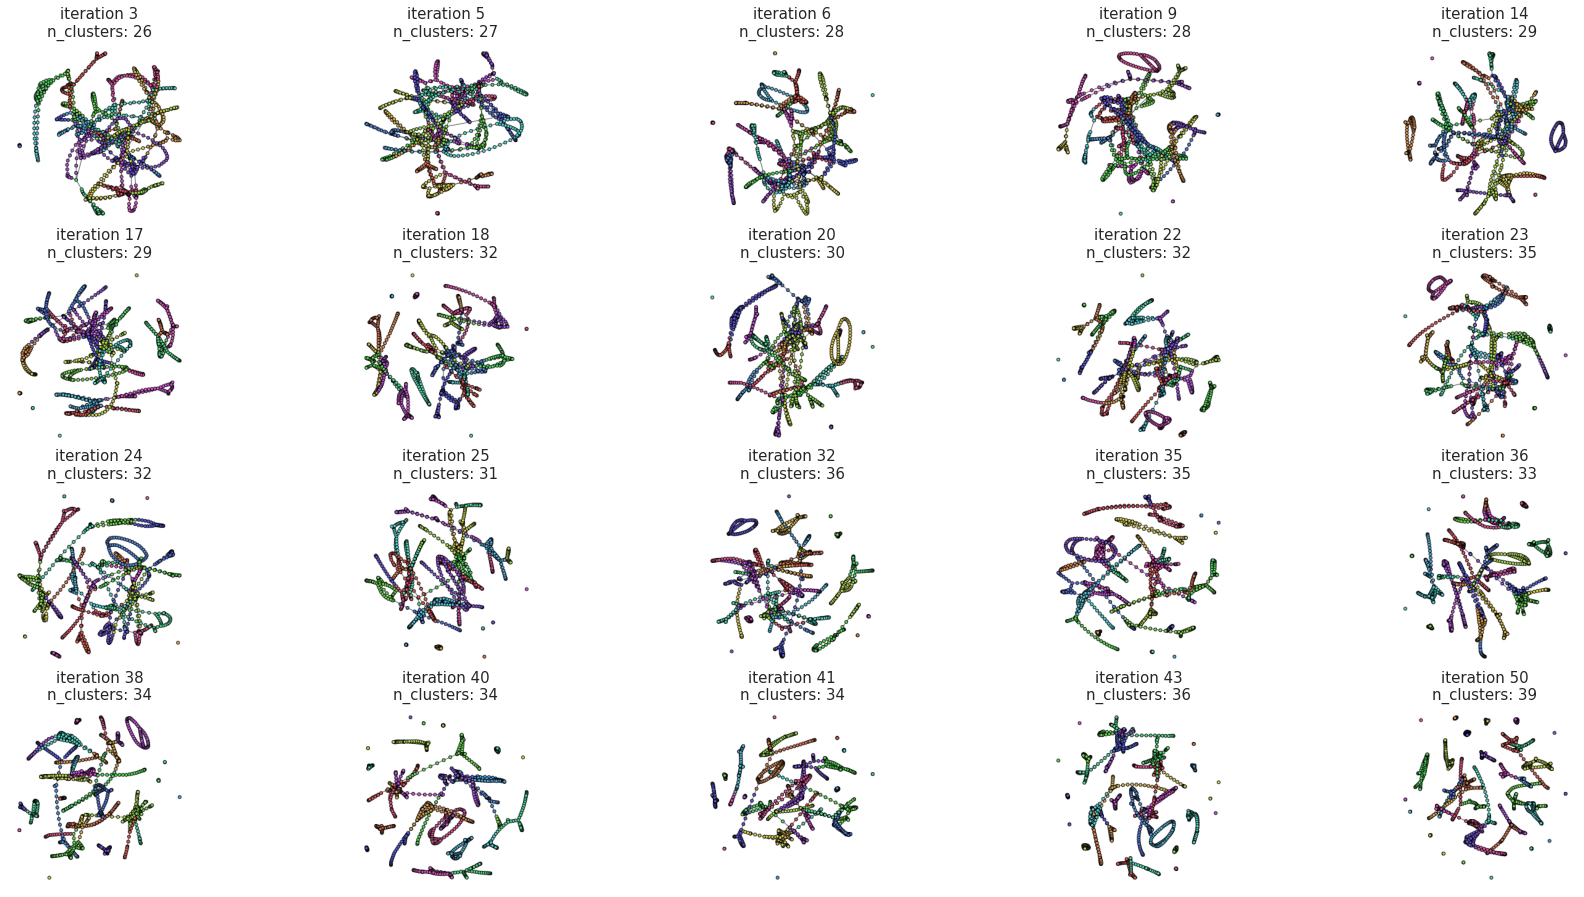

In [74]:
plt.figure(figsize=(30, 40))
plot_graphs(sample=True)

Clusters become more and more separated across iterations as expected. we should check whether we get to a condition in which we have pretty well separated clusters consisting of multiple nodes (i.e. not only one node clusters)

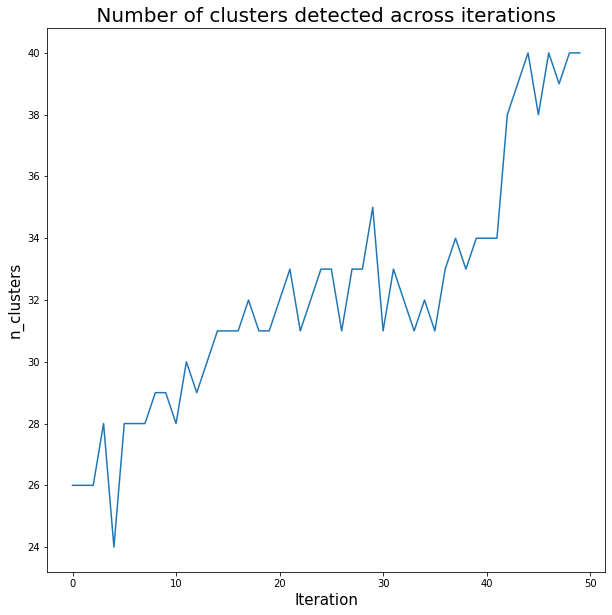

In [ ]:
plt.figure(figsize=(10,10))
s = sns.lineplot(x='iteration', y='n_clusters', data=metrics)
s.set_xlabel("Iteration",fontsize=15)
s.set_ylabel("n_clusters",fontsize=15)
plt.title(" Number of clusters detected across iterations ", fontsize=20);

### Shortest path changes between node pairs across iterations

In [76]:
def shortest_path_graph(graph, gspaths, iteration, delete_previous_plots=True):
  """
  graph: current subgraph or main graph 
  gspaths: all the graph shortest paths being monitored at the current iteration
  """
  if not os.path.exists('shortest_paths/'):
    os.mkdir('shortest_paths/')

  if delete_previous_plots and iteration==1:
    for c in glob.glob('shortest_paths/spaths*png'):
      os.remove(c)

  # set default layout properties
  layout_gr = graph.layout('auto')
  colors =np.random.permutation(sns.color_palette("hls", len(gspaths))).tolist()
  graph.vs['color'] = ['black']
  graph.vs['size'] = 2

  i = 0

  # iterate over all the node pairs for which the shortest path are computed at each iteration 
  for spaths in gspaths:
        # pick paths related to one pair of node in the list
        paths = gspaths[spaths]
        # each pair might contain more than one shortest path (not sure why...but it returns a list)
        for path in paths:
          # assign properties to highlight all the paths associated to the analysed pair of nodes. 
          for n in path:
            graph.vs[n]['color'] = colors[i]
            graph.vs[n]['size'] = 8
        i+=1
  visual_style = {}
  visual_style["vertex_size"] = graph.vs['size']
  visual_style["vertex_label"]=None
  visual_style["vertex_color"] = graph.vs['color']
  visual_style["layout"] = layout_gr
  visual_style["edge_width"] = 1
  visual_style["bbox"] = (300, 300)
  pl = ig.plot(graph, **visual_style)
  pl.save('shortest_paths/spaths_iteration_{}.png'.format(iteration))

def plot_shortest_paths(img_path='shortest_paths/', plot_limit=20, sample=False):
  i = 1
  # retrieve image fileanmes and sort them accordingly to iteration
  img_list = glob.glob(os.path.join(img_path,'spaths*.png'))

  # sample images or pick the first 0 to plot_limit ones
  if sample and len(img_list) > plot_limit:
    img_list = random.sample(img_list, plot_limit)
  else:
    img_list = img_list[:plot_limit]

  img_list.sort(key = lambda x: int(x.split('_')[-1][:-4]))
  
  # set subplot dimensions
  if len(img_list)%2!=0:
    rows = len(img_list)//2
    cols = len(img_list)//4 + 1
  else:
    rows = len(img_list)//2
    cols = len(img_list)//4

  if rows==0 and cols==0:
    rows = 1
    cols=1
  elif rows == 0:
    rows=1

  for imf in img_list:
      im = imread(imf)
      plt.subplot(rows,cols,i)
      plt.imshow(im)
      t = 'shortest paths iteration ' + imf.split('_')[-1][:-4]
      plt.title(t, fontsize=15)
      plt.xticks([])
      plt.yticks([])
      i += 1

In [ ]:
for r in metrics.to_dict(orient="records"):
  shortest_path_graph(r['subgraph'], r['shortest_paths'], r['iteration'])

In [82]:
for r in metrics.to_dict(orient="records"):
  spaths=r['shortest_paths']
  msg = ', '.join(['ITER{} n_nodes for {}: {}'.format(r['iteration'], i, len(spaths[i][0])) for i in spaths ])
  print(msg)

ITER0 n_nodes for (617, 40): 13, ITER0 n_nodes for (20, 1203): 18, ITER0 n_nodes for (123, 740): 14, ITER0 n_nodes for (234, 369): 20
ITER1 n_nodes for (617, 40): 21, ITER1 n_nodes for (20, 1203): 29, ITER1 n_nodes for (123, 740): 15, ITER1 n_nodes for (234, 369): 22
ITER2 n_nodes for (617, 40): 29, ITER2 n_nodes for (20, 1203): 46, ITER2 n_nodes for (123, 740): 13, ITER2 n_nodes for (234, 369): 23
ITER3 n_nodes for (617, 40): 29, ITER3 n_nodes for (20, 1203): 47, ITER3 n_nodes for (123, 740): 13, ITER3 n_nodes for (234, 369): 23
ITER4 n_nodes for (617, 40): 21, ITER4 n_nodes for (20, 1203): 48, ITER4 n_nodes for (123, 740): 14, ITER4 n_nodes for (234, 369): 23
ITER5 n_nodes for (617, 40): 21, ITER5 n_nodes for (20, 1203): 49, ITER5 n_nodes for (123, 740): 15, ITER5 n_nodes for (234, 369): 23
ITER6 n_nodes for (617, 40): 21, ITER6 n_nodes for (20, 1203): 49, ITER6 n_nodes for (123, 740): 15, ITER6 n_nodes for (234, 369): 23
ITER7 n_nodes for (617, 40): 23, ITER7 n_nodes for (20, 1203):

In [81]:
metrics[metrics['iteration']==31]['shortest_paths']

31    {'(617, 40)': [[]], '(20, 1203)': [[]], '(123,...
Name: shortest_paths, dtype: object

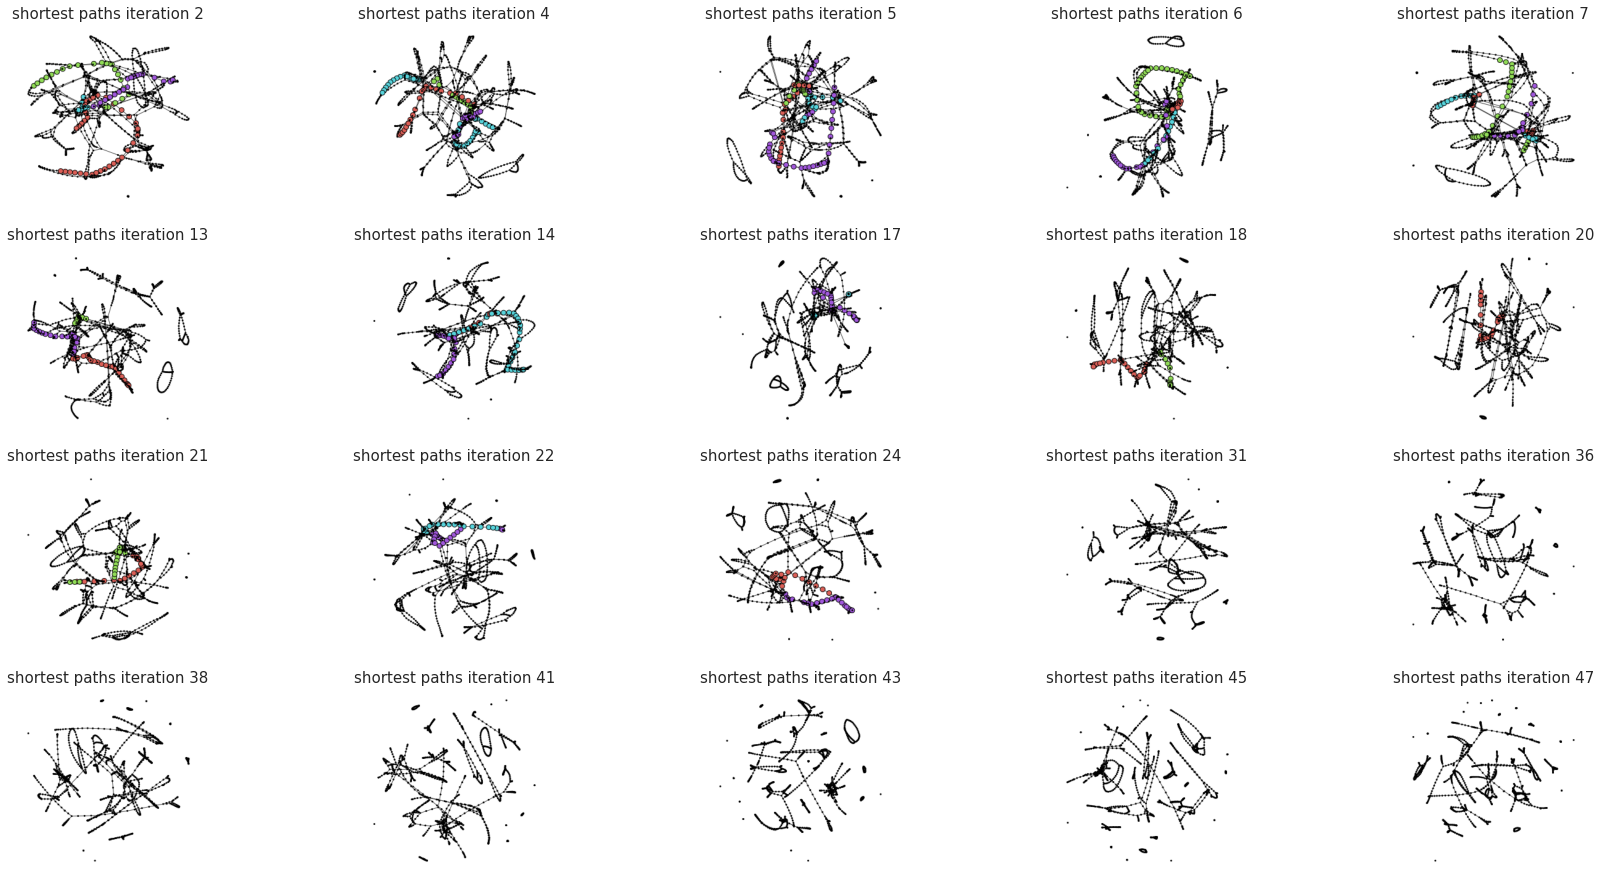

In [78]:
plt.figure(figsize=(30, 40))
plot_shortest_paths()

3) Approach of most central node selection taken from excercise session 3

In [ ]:
# z_undirected = z.copy()
# z_undirected.to_undirected()
# lvn = z_undirected.community_multilevel()
# lvn.modularity
# communities = lvn.subgraphs()

# def getCentralSubStops(subgraph):
#   wdeg = subgraph.strength()
#   betw = subgraph.betweenness()
#   ## Select nodes which belong to the top 5% most central nodes based on both weighted degree and betweenness
#   centrals = subgraph.es[np.where((wdeg>=np.percentile(wdeg,95))& (betw>=np.percentile(betw, 95)))[0].tolist()]
#   return centrals
# centrals = getCentralSubStops(communities[0])
# print(centrals)